# In-lab data vs. Online data

### We want to understand if there is any difference in data quality between in-lab and online data. Past research has shwon in-lab data and online data are essentially the same in terms of data quality (Buhrmester et al., 2011; Gould et al., 2015; Reimers et al., 2015; Crump et al., 2013). But this is the first time, to our knowledge, that experiments framed in free-operant setting, were conducted online. Free-operant setting is special in the sense that nothing prompts the subjects to act. As such, subjects may respond at a rate of their own choosing within a given period of time, in either continuous or discrete manner. Futhermore, we require continuous engagement of subjects. 

### We use the following predictors:
* Latency by environment
* Environment

### Specifically, we want to answer these two questions:
First, is there evidence of a difference between in-lab data and online data?
<br>
Second, if so, which variables are responsible for these differences?

In [30]:
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import json
import seaborn as sns
from sklearn import linear_model
import sklearn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import scipy.stats as ss
%matplotlib inline

In [31]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', None)

In [94]:
# import in-lab data and convert to panda dataframe
mat = sio.loadmat('untransformeddataforRN.mat', squeeze_me=True)
m = mat['untransformed_data']
in_lab = pd.DataFrame(m)
in_lab.columns = ['latency', 'price_displayed', 
             'id', 'price_bin', 'apathy', 'environment_binary']
#in_lab = in_lab[['latency', 'price_displayed', 'id', 'environment_binary']]

In [95]:
# add a label for all in_lab data
in_lab['label'] = [1]*len(in_lab)
in_lab.head(1)

,latency,price_displayed,id,price_bin,apathy,environment_binary,label
0,128.0,1.2,1.0,4.0,12.0,1.0,1


In [34]:
#import online data and add lables for all online data
online = pd.read_csv('fish_100.csv', sep = ",")
online['label'] = [0]*len(online)
online['environment_binary'] = np.where(online['environment']=='low', 0, online['environment_binary'])
online['environment_binary'] = np.where(online['environment']=='high', 1, online['environment_binary'])

In [35]:

online = online [['latency', 'price_displayed', 'id', 'environment_binary', 'label']]
                  

In [36]:
data = pd.concat([in_lab, online])

In [37]:
data = data.dropna()

In [42]:
data_model = data.groupby(['id', 'environment_binary', 'label'])['latency'].mean().reset_index(name = 'average_latency')


## Visualization 

In [88]:
in_lab_avg_latency = data_model[(data_model.label== 1)].average_latency
online_avg_latency = data_model[(data_model.label == 0)].average_latency

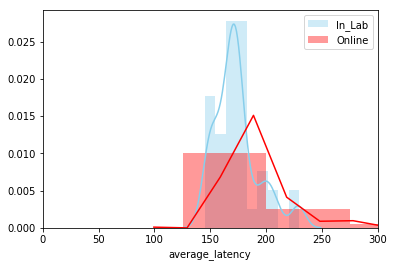

In [93]:
sns.distplot(in_lab_avg_latency , color="skyblue", label="In_Lab")
sns.distplot(online_avg_latency , color="red", label="Online")
plt.legend()
plt.xlim(0, 300)
plt.show()

## Mixed Linear Model

In [97]:
import statsmodels.formula.api as smf
from patsy import dmatrices

In [107]:
formula = "latency ~ price_displayed + environment_binary"

md  = smf.mixedlm(formula, data, groups=data["id"])
mdf = md.fit()
print(mdf.summary())





                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     latency      
No. Observations:       379958      Method:                 REML         
No. Groups:             121         Scale:                  18086445.8079
Min. group size:        1088        Likelihood:             -3713957.4664
Max. group size:        5069        Converged:              Yes          
Mean group size:        3140.1                                           
-------------------------------------------------------------------------
                            Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------
Intercept                   210.234   27.868  7.544 0.000 155.615 264.854
environment_binary[T.1.0]    18.487   13.848  1.335 0.182  -8.655  45.629
price_displayed              -7.380    8.178 -0.902 0.367 -23.407   8.648
Group Var                 71038.488    2.272            

In [105]:
fe_params = pd.DataFrame(mdf.fe_params,columns=['LMM'])
random_effects = pd.DataFrame(mdf.random_effects)
random_effects = random_effects.transpose()
random_effects = random_effects.rename(index=str, columns={'groups': 'LMM'})

In [106]:
fe_params

,LMM
Intercept,202.171216
environment_binary[T.1.0],34.260170
price_displayed,-0.320344
price_displayed:environment_binary[T.1.0],-13.768605


In [103]:
#%% Generate Design Matrix for later use
Y, X   = dmatrices(formula, data=data, return_type='matrix')
Terms  = X.design_info.column_names
_, Z   = dmatrices('latency ~ -1+id', data=data, return_type='matrix')
X      = np.asarray(X) # fixed effect
Z      = np.asarray(Z) # mixed effect
Y      = np.asarray(Y).flatten()
nfixed = np.shape(X)
nrandm = np.shape(Z)

## Split data

In [43]:
X = data_model[['average_latency', 'id', 'environment_binary']]
y = data_model['label']


In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


## SVC

In [47]:
from sklearn.svm import SVC


In [48]:
#Support Vector Classifier
s_clf = SVC()
s_clf.fit(X_train, y_train)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [49]:
s_prediction = s_clf.predict(X_test)
print (s_prediction)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [50]:
from sklearn.metrics import accuracy_score

In [65]:
s_acc = accuracy_score(s_prediction, y_test)
s_acc

0.8688524590163934

The model is guessing in this case; There are 21 in lab participants and 100 (100/121 = 0.82) online subjects.
Due to such imbalance of classes, the model can always guess 0 (the predominant one) and get above chance.

In particular, classifier quality measures like area under the ROC curve (AUC) can be used to assess the degree of difference between the original datasets: small AUC values suggest that the original datasets are similar, while large AUC values suggest substantial differences. If differences are detected, the random permutation strategy described in the companion vignette “Assessing Variable Importance for Predictive Models of Arbitrary Type” can be applied to determine which variables from the original datasets are most responsible for their differences.

In [59]:
from sklearn.metrics import roc_curve, auc

In [60]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, s_prediction)
roc_auc = auc(false_positive_rate, true_positive_rate)

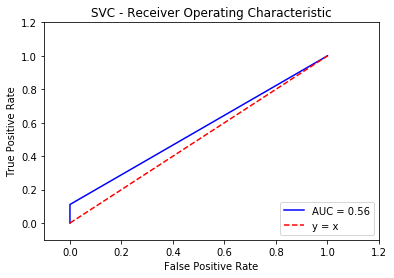

In [73]:
plt.title('SVC - Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--', label = 'y = x')
plt.legend(loc='lower right')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()